### SGLD on 1D Gaussian

**Gaussian distribution pdf**:

\begin{align}
p(x|\mu, \sigma^2) &= \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{(x-\mu)^2}{2\sigma^2} \right) \\
&= \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{x^2-2x\mu+\mu^2}{2\sigma^2} \right)
\end{align}

\begin{align}
    \frac{\partial \log p(x|\mu, \sigma^2)}{\partial x} &= -\frac{x-\mu}{\sigma^2} \\
    \frac{\partial \log p(x|\mu, \sigma^2)}{\partial \mu} &= \frac{x-\mu}{\sigma^2}
\end{align}

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

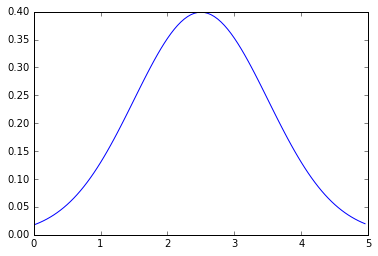

In [3]:
x = np.linspace(0, 5, 100, endpoint=False)
y = norm.pdf(x, loc=2.5, scale=1)

plt.plot(x,y)

## Simple Gaussian Model
\begin{align}
    \theta &\sim \mathcal{N}(0,\sigma_0) \\
    x_n|\theta &\sim \mathcal{N}(\theta,\sigma_x^2)
\end{align}

We would like to sample from the posterior $p(\theta|X)$ and assume that we know $\sigma_x^2$.


### Exact Posterior Derivation

\begin{align}
    \log p(\theta|X) &\propto \log p(\theta) + \sum_n \log p(x_n|\theta) \\
    &= -\frac{\theta^2}{2\sigma_0^2} - \frac{\sum_n (x_n-\theta)^2}{2\sigma_x^2} \\
    &= -\frac{\theta^2}{2\sigma_0^2} - \frac{\sum_n x_n^2-2x_n\theta + \theta^2}{2\sigma_x^2} \\
    &\propto -\frac{\theta^2}{2}\left(\frac{1}{\sigma_0^2} + \frac{N}{\sigma_x^2} \right) + \theta \frac{\sum_n x_n}{\sigma_x^2}
\end{align}

\begin{align}
    p(\theta|X) = \mathcal{N} \left(  \frac{\sigma_0^2\sum_n x_n}{\sigma_x^2+N\sigma_0^2}, \left( \frac{1}{\sigma_0^2} + \frac{N}{\sigma_x^2} \right)^{-1} \right)
\end{align}

### Exact Posterior Computation

theta = 0.10937173888941994


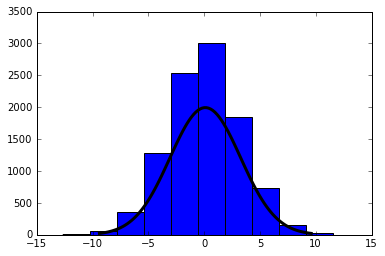

ML estimate = 0.0656857717217
posterior mean = 0.0656201515702
posterior variance = 0.000999000999000999


In [5]:
var_0 = 1
var_x = 10
sigma_0 = np.sqrt(var_0)
sigma_x = np.sqrt(var_x)
N = 10000

# generate theta
theta = np.random.normal(0,sigma_0)
print("theta = " + str(theta))

# generate observations
X = np.random.normal(theta, sigma_x, size=N)

# visualize
n, bins, patches = plt.hist(X);
x=np.linspace(theta-3*sigma_x,theta+3*sigma_x,100)
plt.plot(x,sigma_x*N/2*norm.pdf(x,theta,sigma_x),color='k',linewidth=3);
plt.show()

# ML estimation
theta_ml = np.mean(X)
print("ML estimate = " + str(theta_ml))

# Exact posterior
p_mean = var_0*X.sum()/(var_x+N*var_0)
p_var = 1/(1/var_0 + N/var_x)
print("posterior mean = " + str(p_mean))
print("posterior variance = " + str(p_var))

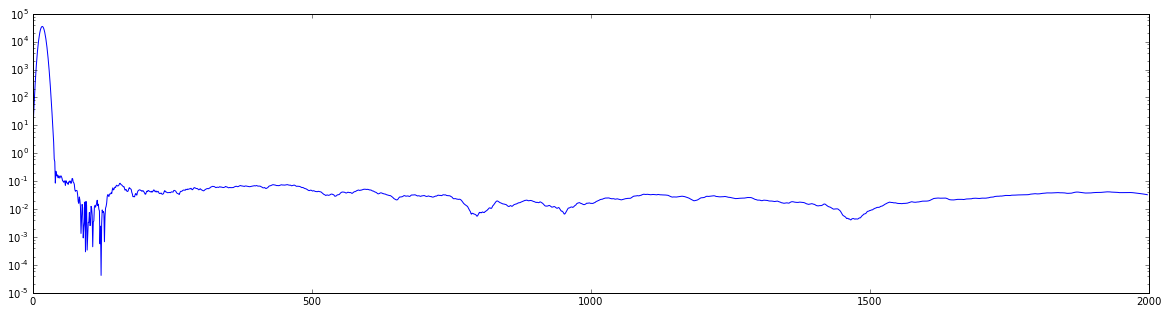

In [6]:
def gradient(theta, var_0, var_x, X_, N):
    grad_prior = -theta/var_0
    grad_obs = (np.sum(X_)-len(X_)*theta)/var_x
    return grad_prior + N/len(X_)*grad_obs
    
a_eps = 1e-4
pow_ = 0.51
T = int(2*1e3)
samples = np.zeros(T)
theta_ = 0
N_gamma = int(N/1000)

for t in range(T):
    X_ = np.random.choice(X, size=N_gamma, replace=False)
    grad = gradient(theta_, var_0, var_x, X_, N)
    eps = np.power((a_eps/(t+1)),pow_)
    nu = np.sqrt(2*eps)*np.random.normal()
    delta_theta = eps*grad + nu
    theta_ += delta_theta
    samples[t] = theta_

plt.figure(figsize=(20,5))
diff = np.zeros(T-1)
for t in range(1,T-1):
    diff[t-1] = np.abs(np.mean(samples[0:t])-theta)
# plt.ylim((0))
plt.semilogy(diff)

## Second Model: Gaussian Mixture Prior
\begin{align}
    \theta &\sim \sum_k w_k \mathcal{N}(\theta;\mu_k,\sigma_k^2I) \\
    x_n|\theta &\sim \mathcal{N}(x_n;a_n^{\text{T}}\theta,\sigma_x^2) \\
    X|\theta &\sim \mathcal{N}(X;A\theta,\sigma_x^2I) \text{, where } A=[a_1^T,a_2^T,\cdots,a_N^T]^T \\
    \theta|X &\propto \sum_k w_k\mathcal{N}(\theta;\mu_{p,k},\Sigma_{p,k})
\end{align}
where
\begin{align}
    \Sigma_{p,k} &= \left( \frac{1}{\sigma_k^2}I + \frac{1}{\sigma_x^2}A^TA \right)^{-1} \\
    \mu_{p,k} &= \Sigma_{p,k} \left(\frac{1}{\sigma_x^2}A^TX + \frac{1}{\sigma_k^2}\mu_k \right)
\end{align}
   
   
#### Gradient of Log-Posterior
\begin{align}
    \log p(\theta|X) &\propto \log p(\theta) + \log p(X|\theta) \\
    &= \log \sum_k w_k \mathcal{N}(\theta;\mu_k,\sigma_k^2I) + \sum_n \log \mathcal{N}(x_n;a_n^{\text{T}}\theta,\sigma_x^2)
\end{align}
\begin{align}
    \frac{\partial \log p(\theta)}{\partial\theta} &= \frac{\partial \sum_k w_k (2\pi\sigma_k^2)^{-\frac{d}{2}} \exp\left(-\frac{1}{2\sigma_k^2}(\theta-\mu_k)^T(\theta-\mu_k)\right) }{\sum_k w_k \mathcal{N}(\theta;\mu_k,\sigma_k^2I)} \\
    &= \frac{\sum_k -w_k \left(\frac{\theta-\mu_k}{\sigma_k^2}\right) \mathcal{N}(\theta;\mu_k,\sigma_k^2I) } {\sum_k w_k \mathcal{N}(\theta;\mu_k,\sigma_k^2I)} \\
    \frac{\partial \log p(X|\theta)}{\partial\theta} &= \frac{(x_n-a_n^T\theta)}{\sigma_x^2}a_n
\end{align}


### Appendix: Product of Two Gaussians
\begin{align}
    f(x) &= \mathcal{N}(\mu_f,\sigma_f^2) \\
    g(x) &= \mathcal{N}(\mu_g,\sigma_g^2) \\
    f(x)g(x) &\propto \mathcal{N}(\mu_p,\sigma_p^2) \\
    \sigma_p^2 = \frac{\sigma_f^2\sigma_g^2}{\sigma_f^2+\sigma_g^2} &\text{, } \mu_p = \frac{\mu_f\sigma_g^2 + \mu_g\sigma_f^2}{\sigma_f^2+\sigma_g^2}
\end{align}